In [1]:
import torch
import torchvision
import ignite

print(*map(lambda m: ": ".join((m.__name__, m.__version__)), (torch, torchvision, ignite)), sep="\n")

torch: 2.2.0+cu118
torchvision: 0.17.0+cu118
ignite: 0.4.13


In [2]:
import os
import logging
import matplotlib.pyplot as plt

import cv2
import numpy as np

from torchsummary import summary

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.utils import save_image
import torchvision.datasets as dset
import torchvision.utils as vutils

from ignite.engine import Engine, Events
import ignite.distributed as idist


def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

In [3]:
ignite.utils.manual_seed(999)
ignite.utils.setup_logger(name="ignite.distributed.auto.auto_dataloader", level=logging.WARNING)
ignite.utils.setup_logger(name="ignite.distributed.launcher.Parallel", level=logging.WARNING)

<Logger ignite.distributed.launcher.Parallel (WARNING)>

In [4]:
class Option():
    n_epochs = 180   # 훈련할 에포크 수
    batch_size = 9  # 배치의 크기
    lr = 0.0002      # Adam 옵티마이저의 학습률
    b1 = 0.5         # Adam 옵티마이저의 그래디언트의 일차 모멘텀 감쇠
    b2 = 0.999       # Adam 옵티마이저의 그래디언트의 이차 모멘텀 감쇠
    n_cpu = 16        # 배치 생성 중에 사용할 CPU 스레드 수
    latent_dim = 200 # 잠재 공간의 차원
    img_size = 256    # 각 이미지 차원의 크기
    channels = 3     # 이미지 채널 수
    sample_interval = 500  # 이미지 샘플링 간격

opt = Option()

In [5]:
data_transform = transforms.Compose(
    [
        transforms.Resize(opt.img_size),
        transforms.CenterCrop(opt.img_size),
        # transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)),
    ]
)
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
train_dataset = dset.ImageFolder(root="datasets/HighResolution/FLIR", transform=data_transform)
test_dataset = torch.utils.data.Subset(train_dataset, torch.arange(3000))

In [6]:
train_dataloader = DataLoader(
    train_dataset, 
    batch_size=opt.batch_size, 
    num_workers=8, 
    shuffle=True, 
    drop_last=True,
)

test_dataloader = DataLoader(
    test_dataset, 
    batch_size=opt.batch_size, 
    num_workers=8, 
    shuffle=False, 
    drop_last=True,
)

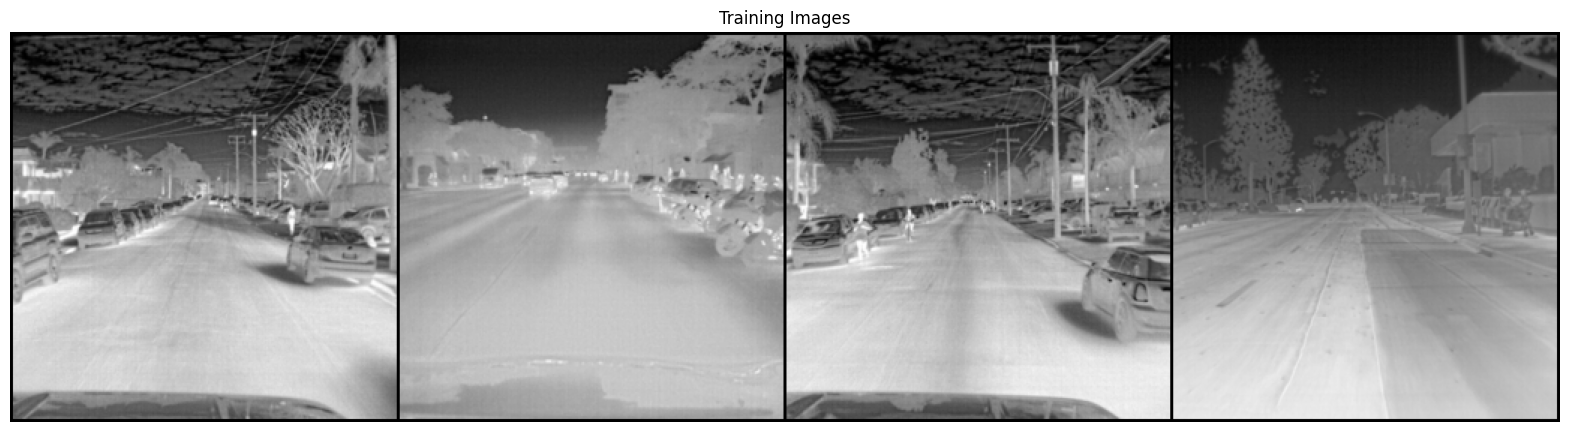

torch.Size([3, 256, 256])


In [7]:
real_batch = next(iter(train_dataloader))

plt.figure(figsize=(20,20))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0][:4], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()
print(real_batch[0][0].shape)

In [8]:
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(in_channels=latent_dim, out_channels=1024, 
                               kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(1024),
            nn.SELU(True),
            # state size. 1024 x 4 x 4

            nn.ConvTranspose2d(1024, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.SELU(True),
            # state size. 512 x 8 x 8

            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.SELU(True),
            # state size. 256 x 16 x 16

            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.SELU(True),
            # state size. 128 x 32 x 32

            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.SELU(True),
            # state size. 64 x 64 x 64            

            nn.ConvTranspose2d(64, 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.SELU(True),
            # state size. 1 x 128 x 128

            nn.ConvTranspose2d(32, 3, 4, 2, 1, bias=False),
            nn.Tanh(),
            # state size. 1 x 256 x 256
        )

    def forward(self, x):
        x = self.model(x)
        return x

In [9]:
generator = Generator(opt.latent_dim)
generator = generator.to(device)

In [10]:
# summary(generator, (opt.latent_dim, 1, 1))

In [11]:
# summary(netG, input_size=(1, 1, opt.latent_dim),)

In [12]:
import torch.nn as nn

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            # input is 1 x 256
            nn.Conv2d(3, 8, 4, 2, 1, bias=False),
            nn.SELU(inplace=True),
            # state size. 8 x 128

            nn.Conv2d(8, 16, 4, 2, 1, bias=False),
            nn.BatchNorm2d(16),
            nn.SELU(inplace=True),
            # state size. 16 x 64

            nn.Conv2d(16, 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.SELU(inplace=True),
            # state size. 32 x 32

            nn.Conv2d(32, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.SELU(inplace=True),
            # state size. 64 x 16

            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.SELU(inplace=True),
            # state size. 128 x 8

            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.SELU(inplace=True),
            # state size. 256 x 4

            nn.Flatten(),
            nn.Linear(256*4*4, 1),
        )

    def forward(self, x):
        x = self.model(x)
        # 여기서 x는 Discriminator의 raw score가 됩니다.
        return x


In [13]:
discriminator = Discriminator()
discriminator = discriminator.to(device)
# summary(discriminator, (1, 256, 256))

In [14]:
adversarial_loss = torch.nn.MSELoss()

In [15]:
fixed_noise = torch.randn(10, opt.latent_dim, 1, 1, device=device)

In [16]:
adversarial_loss = adversarial_loss.to(device=device)

generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

optimizer_G = torch.optim.Adam(generator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
Tensor = torch.cuda.FloatTensor if device else torch.FloatTensor


In [17]:
real_label = 1
fake_label = 0

def training_step(engine, data):
    generator.train()
    discriminator.train()
    real = data[0].to(device)
    b_size = real.size(0)
    valid = torch.full((b_size,), real_label, dtype=torch.float, device=device)
    fake = torch.full((b_size,), fake_label, dtype=torch.float, device=device)
    

    optimizer_G.zero_grad()
    z = torch.randn(b_size, opt.latent_dim, 1, 1, device=device)
    gen_imgs = generator(z)
    D_G_z2 = discriminator(gen_imgs).view(-1)
    g_loss = adversarial_loss(D_G_z2, valid)
    g_loss.backward()
    optimizer_G.step()


    optimizer_D.zero_grad()
    D_x = discriminator(real).view(-1)
    real_loss = adversarial_loss(D_x, valid)

    D_G_z1 = discriminator(gen_imgs.detach()).view(-1)
    fake_loss = adversarial_loss(D_G_z1, fake)
    d_loss = (real_loss + fake_loss) / 2
    d_loss.backward()
    optimizer_D.step()

    return {
        "Loss_G" : g_loss.item(),
        "Loss_D" : d_loss.item(),
        "D_x": D_x.mean().item(),
        "D_G_z1": D_G_z1.mean().item(),
        "D_G_z2": D_G_z2.mean().item(),
    }


In [18]:
trainer = Engine(training_step)

In [19]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

In [20]:
@trainer.on(Events.STARTED)
def init_weights():
    discriminator.apply(weights_init_normal)
    generator.apply(weights_init_normal)

In [21]:
G_losses = []
D_losses = []

@trainer.on(Events.ITERATION_COMPLETED)
def store_losses(engine):
    o = engine.state.output
    G_losses.append(o["Loss_G"])
    D_losses.append(o["Loss_D"])

In [22]:
img_list = []

@trainer.on(Events.ITERATION_COMPLETED(every=500))
def store_images(engine):
    with torch.no_grad():
        fake = generator(fixed_noise).cpu()
    img_list.append(fake)

In [23]:
import PIL.Image as Image


def interpolate(batch):
    arr = []
    for img in batch:
        pil_img = transforms.ToPILImage()(img)
        arr.append(transforms.ToTensor()(pil_img))
    return torch.stack(arr)


def evaluation_step(engine, batch):
    with torch.no_grad():
        noise = torch.randn(opt.batch_size, opt.latent_dim, 1, 1, device=device)
        generator.eval().to(device=device)
        fake_batch = generator(noise)
        fake = interpolate(fake_batch)
        # print(fake.shape)
        real = interpolate(batch[0])
        # print(real.shape)
        return fake, real

In [24]:
evaluator = Engine(evaluation_step)

In [25]:
from ignite.metrics import FID, InceptionScore
fid_metric = FID(device=device)
is_metric = InceptionScore(device=device, output_transform=lambda x: x[0])

In [26]:
evaluator = Engine(evaluation_step)
fid_metric.attach(evaluator, "fid")
is_metric.attach(evaluator, "is")

In [27]:
fid_values = []
is_values = []


@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(engine):
    evaluator.run(test_dataloader,max_epochs=1)
    metrics = evaluator.state.metrics
    fid_score = metrics['fid']
    is_score = metrics['is']
    fid_values.append(fid_score)
    is_values.append(is_score)
    print(f"Epoch [{engine.state.epoch}/100] Metric Scores")
    print(f"*   FID : {fid_score:4f}")
    print(f"*    IS : {is_score:4f}")
    

    
    with torch.no_grad():
        fake = generator(fixed_noise).to(device)

    epoch_number = engine.state.epoch
    image_filename = f"img/FLIR_LSGAN/{epoch_number}_epoch.png"
    save_image(fake.data[:10], image_filename, nrow=5, normalize=True)

    # img = cv2.imread(image_filename)
    # plt.figure(figsize=(30, 30))
    # plt.imshow(img, interpolation='nearest')
    # plt.axis('off')
    # plt.show()


In [28]:
from ignite.metrics import RunningAverage

RunningAverage(output_transform=lambda x: x["Loss_G"]).attach(trainer, 'Loss_G')
RunningAverage(output_transform=lambda x: x["Loss_D"]).attach(trainer, 'Loss_D')

In [29]:
from ignite.contrib.handlers import ProgressBar

ProgressBar().attach(trainer, metric_names=['Loss_G','Loss_D'])
ProgressBar().attach(evaluator)

/home/gpuadmin/anaconda3/envs/torch/lib/python3.8/site-packages/ignite/contrib/handlers/tqdm_logger.py:126: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [30]:
def training(*args):
    trainer.run(train_dataloader, max_epochs=opt.n_epochs)

In [31]:
real_batch = next(iter(train_dataloader))
print(real_batch[0].shape)

torch.Size([9, 3, 256, 256])


In [32]:
training()

Epoch [1/100] Metric Scores
*   FID : 0.226927
*    IS : 1.391973


Epoch [2/100] Metric Scores
*   FID : 0.221982
*    IS : 1.337381


Epoch [3/100] Metric Scores
*   FID : 0.329050
*    IS : 1.830782


Epoch [4/100] Metric Scores
*   FID : 0.249056
*    IS : 1.692152


Epoch [5/100] Metric Scores
*   FID : 0.539066
*    IS : 1.854084


Epoch [6/100] Metric Scores
*   FID : 0.289135
*    IS : 2.125756


Epoch [7/100] Metric Scores
*   FID : 0.246814
*    IS : 1.624003


Epoch [8/100] Metric Scores
*   FID : 0.266011
*    IS : 2.013643


Epoch [9/100] Metric Scores
*   FID : 0.263452
*    IS : 2.124025


Epoch [10/100] Metric Scores
*   FID : 0.278522
*    IS : 2.230141


Epoch [11/100] Metric Scores
*   FID : 0.318874
*    IS : 2.414327


Epoch [12/100] Metric Scores
*   FID : 0.365978
*    IS : 2.363215


Epoch [13/100] Metric Scores
*   FID : 0.336289
*    IS : 2.199105


Epoch [14/100] Metric Scores
*   FID : 0.342346
*    IS : 2.568583


Epoch [15/100] Metric Scores
*   FID : 0.446472
*    IS : 2.512063


Epoch [16/100] Metric Scores
*   FID : 0.505271
*    IS : 2.160779


Epoch [17/100] Metric Scores
*   FID : 0.466838
*    IS : 2.356545


Epoch [18/100] Metric Scores
*   FID : 0.438856
*    IS : 2.325687


Epoch [19/100] Metric Scores
*   FID : 0.467344
*    IS : 2.238589


Epoch [20/100] Metric Scores
*   FID : 0.363804
*    IS : 2.405993


Epoch [21/100] Metric Scores
*   FID : 0.408365
*    IS : 2.239703


Epoch [22/100] Metric Scores
*   FID : 0.362561
*    IS : 2.262024


Epoch [23/100] Metric Scores
*   FID : 0.341913
*    IS : 2.278681


Epoch [24/100] Metric Scores
*   FID : 0.369775
*    IS : 2.554283


Epoch [25/100] Metric Scores
*   FID : 0.228028
*    IS : 1.032000


Epoch [26/100] Metric Scores
*   FID : 0.228677
*    IS : 1.023067


Epoch [27/100] Metric Scores
*   FID : 0.228324
*    IS : 1.031897


Epoch [28/100] Metric Scores
*   FID : 0.228113
*    IS : 1.030734


Epoch [29/100] Metric Scores
*   FID : 0.228421
*    IS : 1.029711


Epoch [30/100] Metric Scores
*   FID : 0.228541
*    IS : 1.034536


Epoch [31/100] Metric Scores
*   FID : 0.451812
*    IS : 1.409251


Epoch [32/100] Metric Scores
*   FID : 0.234865
*    IS : 1.047539


Epoch [33/100] Metric Scores
*   FID : 0.294393
*    IS : 1.238960


Epoch [34/100] Metric Scores
*   FID : 0.229275
*    IS : 1.027884


Epoch [35/100] Metric Scores
*   FID : 0.230895
*    IS : 1.042129


Epoch [36/100] Metric Scores
*   FID : 0.229164
*    IS : 1.023148


Epoch [37/100] Metric Scores
*   FID : 0.228572
*    IS : 1.024580


Epoch [38/100] Metric Scores
*   FID : 0.228969
*    IS : 1.024356


Epoch [39/100] Metric Scores
*   FID : 0.237900
*    IS : 1.261281


Epoch [40/100] Metric Scores
*   FID : 0.680144
*    IS : 1.678295


Epoch [41/100] Metric Scores
*   FID : 0.639374
*    IS : 1.906610


Epoch [42/100] Metric Scores
*   FID : 0.229528
*    IS : 1.032271


Epoch [43/100] Metric Scores
*   FID : 0.243137
*    IS : 1.143543


Epoch [44/100] Metric Scores
*   FID : 0.540594
*    IS : 2.035109


Epoch [45/100] Metric Scores
*   FID : 0.230782
*    IS : 1.038303


Epoch [46/100] Metric Scores
*   FID : 0.252568
*    IS : 1.086623


Epoch [47/100] Metric Scores
*   FID : 0.247788
*    IS : 1.060138


Epoch [48/100] Metric Scores
*   FID : 0.229898
*    IS : 1.048463


Epoch [49/100] Metric Scores
*   FID : 0.226835
*    IS : 1.067798


Epoch [50/100] Metric Scores
*   FID : 0.275140
*    IS : 1.454414


Epoch [51/100] Metric Scores
*   FID : 0.992820
*    IS : 1.335001


Epoch [52/100] Metric Scores
*   FID : 0.959393
*    IS : 1.383835


Epoch [53/100] Metric Scores
*   FID : 0.232040
*    IS : 1.040297


Epoch [54/100] Metric Scores
*   FID : 0.236031
*    IS : 1.201330


Epoch [55/100] Metric Scores
*   FID : 0.235609
*    IS : 1.039497


Epoch [56/100] Metric Scores
*   FID : 0.230096
*    IS : 1.061049


Epoch [57/100] Metric Scores
*   FID : 0.239839
*    IS : 1.084409


Epoch [58/100] Metric Scores
*   FID : 0.637466
*    IS : 2.432427


Epoch [59/100] Metric Scores
*   FID : 0.289406
*    IS : 1.165390


Epoch [60/100] Metric Scores
*   FID : 0.572482
*    IS : 1.710130


Epoch [61/100] Metric Scores
*   FID : 0.572208
*    IS : 2.303984


Epoch [62/100] Metric Scores
*   FID : 0.519218
*    IS : 2.234438


Epoch [63/100] Metric Scores
*   FID : 0.255758
*    IS : 1.119538


Epoch [64/100] Metric Scores
*   FID : 0.231005
*    IS : 1.023169


Epoch [65/100] Metric Scores
*   FID : 0.239104
*    IS : 1.048881


Epoch [66/100] Metric Scores
*   FID : 0.306706
*    IS : 1.916371


Epoch [67/100] Metric Scores
*   FID : 0.350921
*    IS : 1.963049


Epoch [68/100] Metric Scores
*   FID : 0.687527
*    IS : 1.679608


Epoch [69/100] Metric Scores
*   FID : 0.234196
*    IS : 1.096275


Epoch [70/100] Metric Scores
*   FID : 0.236232
*    IS : 1.026149


Epoch [71/100] Metric Scores
*   FID : 0.379433
*    IS : 1.829839


Epoch [72/100] Metric Scores
*   FID : 0.605134
*    IS : 1.659973


Epoch [73/100] Metric Scores
*   FID : 1.140458
*    IS : 1.078468


Epoch [74/100] Metric Scores
*   FID : 1.136518
*    IS : 1.080862


Epoch [75/100] Metric Scores
*   FID : 0.949961
*    IS : 1.474373


Epoch [76/100] Metric Scores
*   FID : 0.943560
*    IS : 1.302282


Epoch [77/100] Metric Scores
*   FID : 1.021422
*    IS : 1.280997


Epoch [78/100] Metric Scores
*   FID : 1.004856
*    IS : 1.369934


Epoch [79/100] Metric Scores
*   FID : 1.133393
*    IS : 1.128784


Epoch [80/100] Metric Scores
*   FID : 0.897224
*    IS : 1.335787


Epoch [81/200]: [1737/1737] 100%|██████████, Loss_G=0.313, Loss_D=0.23 [00:57<00:00] 

Epoch [81/100] Metric Scores
*   FID : 0.818869
*    IS : 1.554632


Epoch [82/100] Metric Scores
*   FID : 0.943924
*    IS : 1.455919


Epoch [83/100] Metric Scores
*   FID : 0.877876
*    IS : 1.551018


Epoch [84/100] Metric Scores
*   FID : 0.747054
*    IS : 1.798726


Epoch [85/100] Metric Scores
*   FID : 0.945887
*    IS : 1.371197


Epoch [86/100] Metric Scores
*   FID : 0.912322
*    IS : 1.539246


Epoch [87/100] Metric Scores
*   FID : 0.964871
*    IS : 1.332732


Epoch [88/100] Metric Scores
*   FID : 1.016098
*    IS : 1.301891


Epoch [89/100] Metric Scores
*   FID : 0.969826
*    IS : 1.377417


Epoch [90/100] Metric Scores
*   FID : 0.940122
*    IS : 1.404176


Epoch [91/100] Metric Scores
*   FID : 0.912785
*    IS : 1.389812


Epoch [92/200]: [1737/1737] 100%|██████████, Loss_G=0.362, Loss_D=0.218 [00:57<00:00]

Epoch [92/100] Metric Scores
*   FID : 0.923366
*    IS : 1.391238


Epoch [93/100] Metric Scores
*   FID : 0.836138
*    IS : 1.442579


Epoch [94/100] Metric Scores
*   FID : 0.735990
*    IS : 1.663893


Epoch [95/100] Metric Scores
*   FID : 0.810234
*    IS : 1.556077


Epoch [96/100] Metric Scores
*   FID : 0.829475
*    IS : 1.615734


Epoch [97/100] Metric Scores
*   FID : 0.781999
*    IS : 1.587938


Epoch [98/100] Metric Scores
*   FID : 0.797616
*    IS : 1.598446


Epoch [99/200]: [445/1737]  26%|██▌       , Loss_G=0.426, Loss_D=0.19 [00:11<00:30] 

In [ ]:
%matplotlib inline 

plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()

plt.savefig('LSGAN_training_loss.png')
plt.show()

In [ ]:
fig, ax1 = plt.subplots()

plt.title("Evaluation Metric During Training")

color = 'tab:red'
ax1.set_xlabel('epochs')
ax1.set_ylabel('IS', color=color)
ax1.plot(is_values, color=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('FID', color=color)
ax2.plot(fid_values, color=color)

fig.tight_layout()


fig.savefig('LSGAN_evaluation_metric.png')
plt.show()

In [ ]:
%matplotlib inline

# Grab a batch of real images from the dataloader
real_batch = next(iter(train_dataloader))

# Plot the real images
plt.figure(figsize=(30,30))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0][:9], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(vutils.make_grid(img_list[-1], padding=2, normalize=True).cpu(),(1,2,0)))

plt.savefig('LSGAN_real_fake_images_comparison.png')
plt.show()